In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
device = torch.device('cpu') # 'cpu' can be changed to 'cuda' to run the operations on the GPU
if torch.cuda.is_available():
    device = torch.device('cuda')

# Introduction

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
# Here "Normalize" is used so that features (pixels) have mean 0 and standard deviation 1
# the mean and std of the dataset have been precomputed

In [ ]:
mnist_train = torchvision.datasets.MNIST(root='data/train', download=True, train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root='data/test', download=True, train=False, transform=transform)

Extracting data/train/MNIST/raw/train-images-idx3-ubyte.gz to data/train/MNIST/raw


Extracting data/train/MNIST/raw/train-labels-idx1-ubyte.gz to data/train/MNIST/raw



Extracting data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to data/train/MNIST/raw


Extracting data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/train/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting data/test/MNIST/raw/train-images-idx3-ubyte.gz to data/test/MNIST/raw




Extracting data/test/MNIST/raw/train-labels-idx1-ubyte.gz to data/test/MNIST/raw


Extracting data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to data/test/MNIST/raw


Extracting data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/test/MNIST/raw
Processing...
Done!


In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=32) 
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=256) 

We can have a look at a few digits.

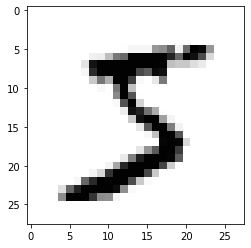

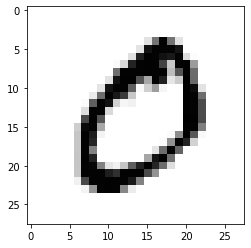

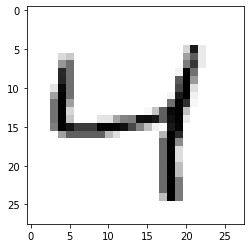

In [ ]:
for i in range(3): # change to see more digits
    plt.imshow(mnist_train.data[i].numpy(), cmap=plt.cm.Greys)
    plt.show()

What we could do is classify these digits using a fully connected neural network. For instance, if we define a model with no hidden layer, this is equivalent to a simple (multi-class) logistic regression.

In [ ]:
import torch.nn as nn

# This model is equivalent to a (multi-class) logistic regression model
class LinearModel(nn.Module):
    def __init__(self, dim, n_classes=10):
        super(LinearModel, self).__init__()
        self.layer_1 = nn.Linear(dim, n_classes)

    def forward(self, x):
        # x will have this shape: (batch_size=32, number_of_channels=1, image_height=28, image_width=28)
        x = x.reshape(-1, 784) # we reshape x to be a vector (so that x have size (batch_size, image_height*image_width))
        x = self.layer_1(x)
        return x

In [ ]:
model = LinearModel(784).to(device) # to(device) is used to put the model on the selected device (CPU or GPU depending of availability)

In [ ]:
# We will use an Adam optimizer with the default learning rate (but we could also use a "standard" Stochastic Gradient Descent)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [ ]:
# Our "criterion" (i.e. loss function) will be a cross entropy loss, the multi-class generalization of the logistic loss
criterion = nn.CrossEntropyLoss()

In [ ]:
# We train the model for 5 epochs
num_epochs = 5 #TODO: change

for _ in tqdm(range(num_epochs)):
  # These are the standard steps when training a model
  for x, y in train_loader: # we iterate over the dataset using the data loader
    optimizer.zero_grad() # we reinitialize the gradients
    x, y = x.to(device), y.to(device) # we put the data on the correct device (CPU or GPU)
    y_hat = model(x) # we make predictions with the model
    loss = criterion(y_hat, y) # we compute the loss
    loss.backward() # we perform back-propagation to compute the gradients of all parameters
    optimizer.step() # we update the parameters using gradient descent

Now we can make predictions on the test dataset and evaluate the performance of the model.

In [ ]:
true_labels = []
predicted_labels = []

for x, y in test_loader: # we iterate over the test dataset
    true_labels.append(y.numpy())
    x, y = x.to(device), y.to(device)
    y_hat = model(x) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
    y_hat = nn.Softmax(dim=0)(y_hat) # these are the estimated probability of belonging to each class
    y_hat = y_hat.argmax(dim=1) # these are the most likely classes
    predicted_labels.append(y_hat.detach().cpu().numpy())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

In [ ]:
print('The accuracy is {:.1f}%'.format(100 * (true_labels == predicted_labels).mean()))

The accuracy is 80.1%


**Important note**: you can notice that we didn't use a softmax to obtain probabilities during training. This is because the CrossEntropyLoss function from Pytorch already applies a softmax (this is actually a log-softmax followed by a negative log-likelihood for numerical stability reasons, but this is really the same thing), so we don't want to apply a softmax twice.

As a result, the network simply output "raw activation weights", and we need to manually apply a softmax to the output if we want to obtain probabilities between O and 1.

**Exercise (as a reminder from the previous lab):** add a hidden layer to the model. Don't forget to use an activation function between the two layers, otherwise the output will still be a linear combination of the input.


In [ ]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self, dim, n_classes=10):
        super(LinearModel, self).__init__()
        self.layer_1 = nn.Linear(dim,dim)
        self.activ1 = nn.Sigmoid()
        self.layer_2 = nn.Linear(dim,n_classes)

    def forward(self, x):
        # x will have this shape: (batch_size=32, number_of_channels=1, image_height=28, image_width=28)
        x = x.reshape(-1, 784) # we reshape x to be a vector (so that x have size (batch_size, image_height*image_width))
        x = self.layer_1(x)
        x = self.activ1(x)
        x = self.layer_2(x)
        return x

In [ ]:
model = LinearModel(784).to(device) # to(device) is used to put the model on the selected device (CPU or GPU depending of availability)

In [ ]:
# We will use an Adam optimizer with the default learning rate (but we could also use a "standard" Stochastic Gradient Descent)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

In [ ]:
# Our "criterion" (i.e. loss function) will be a cross entropy loss, the multi-class generalization of the logistic loss
criterion = nn.CrossEntropyLoss()

In [ ]:
# We train the model for 5 epochs
num_epochs = 5 #TODO: change

for _ in tqdm(range(num_epochs)):
  # These are the standard steps when training a model
  for x, y in train_loader: # we iterate over the dataset using the data loader
    optimizer.zero_grad() # we reinitialize the gradients
    x, y = x.to(device), y.to(device) # we put the data on the correct device (CPU or GPU)
    y_hat = model(x) # we make predictions with the model
    loss = criterion(y_hat, y) # we compute the loss
    loss.backward() # we perform back-propagation to compute the gradients of all parameters
    optimizer.step() # we update the parameters using gradient descent

In [ ]:
true_labels = []
predicted_labels = []

for x, y in test_loader: # we iterate over the test dataset
    true_labels.append(y.numpy())
    x, y = x.to(device), y.to(device)
    y_hat = model(x) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
    y_hat = nn.Softmax(dim=0)(y_hat) # these are the estimated probability of belonging to each class
    y_hat = y_hat.argmax(dim=1) # these are the most likely classes
    predicted_labels.append(y_hat.detach().cpu().numpy())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

In [ ]:
print('The accuracy is {:.1f}%'.format(100 * (true_labels == predicted_labels).mean()))

The accuracy is 97.3%


However, this approach is not very efficient, even with the added non linearity provided by the hidden layer. In particular, the network does not directly encode any information about which pixels are close to each other.

Instead, we can use a more sensible approach and train a convolutional neural network.

# Training convolutional neural networks on black & white images

We will define a very simple convolutional architecture, with a first convolution followed by a Rectified Linear Unit (Relu) activation, followed by a max pooling. We will repeat these steps a second time, and then apply two fully connected layers.

In [ ]:
import torch.nn.functional as F

# This model is our CNN
class SimpleConvNet(nn.Module):
    def __init__(self, n_classes=10):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, n_classes)

    def forward(self, x):
        # x will have this shape: (batch_size=32, number_of_channels=1, image_height=28, image_width=28)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 10 * 4 * 4) # after the convolutions, we reshape x to be a vector for individual images (so that x has size (batch_size, dim_of_vector))
        x = F.relu(self.fc1(x)) # we use Rectified Linear Units (relu) as non linearities
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleConvNet().to(device)

Thanks to the magic of PyTorch and its automatic differentiation API, We can train the model in a similar way to what we did with the fully connected network.

In [ ]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
# We train the model for 5 epochs
num_epochs = 2 #TODO: change

for epoch in range(num_epochs):
    print('EPOCH {}'.format(epoch))
    for x, y in tqdm(train_loader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

EPOCH 0



EPOCH 1


We can make predictions exactly as before

In [ ]:
true_labels = []
predicted_labels = []

for x, y in test_loader: # we iterate over the test dataset
    true_labels.append(y.numpy())
    x, y = x.to(device), y.to(device)
    y_hat = model(x) # these are the "activations" corresponding to each class: the higher the activation, the more likely the class
    y_hat = nn.Softmax(dim=0)(y_hat) # these are the estimated probability of belonging to each class
    y_hat = y_hat.argmax(dim=1) # these are the most likely classes
    predicted_labels.append(y_hat.detach().cpu().numpy())

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)

In [ ]:
print('The accuracy is {:.1f}%'.format(100 * (true_labels == predicted_labels).mean()))

The accuracy is 97.3%


**Questions**: what is the shape of the tensor 'x' inside the forward loop of the model after the second pooling layer? Do you understand why?

Shape: [32, 10, 4, 4]

In [ ]:
'''
Shape: [32, 10, 4, 4]

# This model is our CNN
class SimpleConvNet(nn.Module):
  def __init__(self, n_classes=10):
    super(SimpleConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=5, kernel_size=5)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(5, 10, 5)
    self.fc1 = nn.Linear(10 * 4 * 4, 100)
    self.fc2 = nn.Linear(100, n_classes)

  def forward(self, x):
    # x will have this shape: (batch_size=32, number_of_channels=1, image_height=28, image_width=28)
    print(x.shape) -> torch.Size([32, 1, 28, 28])
    x = F.relu(self.conv1(x))
    print(x.shape) -> torch.Size([32, 5, 24, 24])
    x = self.pool(x)
    print(x.shape) -> torch.Size([32, 5, 12, 12])
    x = F.relu(self.conv2(x))
    print(x.shape) -> torch.Size([32, 10, 8, 8])
    x = self.pool(x)
    print(x.shape) -> torch.Size([32, 10, 4, 4])
    x = x.view(-1, 10 * 4 * 4) # after the convolutions, we reshape x to be a vector for individual images (so that x has size (batch_size, dim_of_vector))
    print(x.shape) -> torch.Size([32, 160])
    x = F.relu(self.fc1(x)) # we use Rectified Linear Units (relu) as non linearities
    print(x.shape) -> torch.Size([32, 100])
    x = self.fc2(x)
    print(x.shape) -> torch.Size([32, 10])
    return x
'''

# Training CNN on color images

Training on color images is exactly the same as training on black on white images. We simply have 3 input channels (Red, Green and Blue) instead of a single one for black and white images. 

 We will use a new dataset, CIFAR-10. This standard dataset can be loaded seamlessly from PyTorch API similarly to MNIST.
 
The dataset contains 10 classes:

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

This part has been adapted from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html.

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# We normalize so that pixels of each channel (the Red, Blue and Green channels) have mean 0 and std 1
# means and std of each channel are assumed to be 0.5

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

We define a convolutional neural network.

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, n_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x